<a href="https://colab.research.google.com/github/dieygomes/tcc_univesp/blob/main/02_analise_temporal_lags_comportamentos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

## 1. Analise temporal Individual

In [ ]:
# Load the datasets
vigitel_df = pd.read_csv('/content/prevalencia_comportamentos_isolados.csv')
incidcancer_df = pd.read_csv('/content/taxas_incidcancer_sp.csv')

# Display columns to identify the correct merge key
print("Columns in vigitel_df:", vigitel_df.columns)
print("Columns in incidcancer_df:", incidcancer_df.columns)

# Merge the dataframes on the specified columns
dados = pd.merge(vigitel_df, incidcancer_df, left_on='ano', right_on='ano_diagnostico', how='inner')

# Display the first few rows of the merged dataframe
display(dados.head())

Columns in vigitel_df: Index(['ano', 'sedentarismo', 'alim_naosaudavel', 'consumo_alcool',
       'tabagismo'],
      dtype='object')
Columns in incidcancer_df: Index(['ano_diagnostico', 'n_absoluto_pulmao', 'n_absoluto_colorretal',
       'n_absoluto_estomago', 'n_absoluto_esofago', 'n_absoluto_figado',
       'População Estimada', 'taxa_pulmao', 'taxa_colorretal', 'taxa_estomago',
       'taxa_esofago', 'taxa_figado'],
      dtype='object')


,ano,sedentarismo,alim_naosaudavel,consumo_alcool,tabagismo,ano_diagnostico,n_absoluto_pulmao,n_absoluto_colorretal,n_absoluto_estomago,n_absoluto_esofago,n_absoluto_figado,População Estimada,taxa_pulmao,taxa_colorretal,taxa_estomago,taxa_esofago,taxa_figado
0,2006,23.28,20.08,11.47,18.22,2006,1512,3278,1649,578,176,7683961.0,19.7,42.7,21.5,7.5,2.3
1,2007,21.81,14.89,12.37,18.35,2007,1620,3398,1550,612,200,7811854.0,20.7,43.5,19.8,7.8,2.6
2,2008,21.67,12.41,12.94,18.33,2008,1550,3513,1417,567,261,7938988.0,19.5,44.2,17.8,7.1,3.3
3,2009,21.63,12.84,14.50,17.05,2009,1602,3867,1351,733,341,8064074.0,19.9,48.0,16.8,9.1,4.2
4,2010,24.71,12.90,14.82,18.62,2010,1590,3820,1461,643,340,8184569.0,19.4,46.7,17.9,7.9,4.2


In [ ]:
# =============================================================================
# ANÁLISE COMPLETA: CORRELAÇÕES SIMPLES E COM LAGS (0-5 ANOS) COM P-VALUES
# =============================================================================

print("🎯 ANÁLISE COMPLETA DE CORRELAÇÕES")
print("=" * 70)

import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# Carregar dados
df_comport = pd.read_csv('prevalencia_comportamentos_isolados.csv')
df_cancer = pd.read_csv('taxas_incidcancer_sp.csv')
df_cancer = df_cancer[df_cancer['ano_diagnostico'] != 2016]
dados = pd.merge(df_comport, df_cancer, left_on='ano', right_on='ano_diagnostico')

# =============================================================================
# 1. CORRELAÇÃO SIMPLES (SEM LAGS)
# =============================================================================

print("\n1. 📊 CORRELAÇÃO SIMPLES (SEM LAGS)")
print("-" * 50)

comportamentos = ['tabagismo', 'consumo_alcool', 'sedentarismo', 'alim_naosaudavel']
cancers = ['taxa_pulmao', 'taxa_esofago', 'taxa_estomago', 'taxa_colorretal', 'taxa_figado']

resultados_correl_simples = []

for comportamento in comportamentos:
    for cancer in cancers:
        dados_clean = dados[[comportamento, cancer]].dropna()
        if len(dados_clean) < 3: continue

        correlacao, p_value = pearsonr(dados_clean[comportamento], dados_clean[cancer])

        # Classificação
        if abs(correlacao) >= 0.7: forca = "MUITO_FORTE"
        elif abs(correlacao) >= 0.5: forca = "FORTE"
        elif abs(correlacao) >= 0.3: forca = "MODERADA"
        else: forca = "FRACA"

        tendencia = "POSITIVA" if correlacao > 0 else "NEGATIVA"
        significancia = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

        resultados_correl_simples.append({
            'comportamento': comportamento, 'cancer': cancer, 'lag': 0,
            'correlacao': correlacao, 'p_value': p_value, 'forca': forca,
            'tendencia': tendencia, 'significancia': significancia,
            'n_observacoes': len(dados_clean)
        })

df_correl_simples = pd.DataFrame(resultados_correl_simples)
significativos_simples = df_correl_simples[df_correl_simples['p_value'] < 0.05]

print(f"✅ Correlações simples analisadas: {len(df_correl_simples)}")
print(f"📈 Correlações significativas (p < 0.05): {len(significativos_simples)}")

if len(significativos_simples) > 0:
    print(f"\n🏆 TOP CORRELAÇÕES SIMPLES:")
    top_simples = significativos_simples.nlargest(5, 'correlacao')
    for idx, row in top_simples.iterrows():
        cancer_nome = row['cancer'].replace('taxa_', '').title()
        print(f"   • {row['comportamento']} → {cancer_nome}: r = {row['correlacao']:.3f} (p = {row['p_value']:.3f})")

# =============================================================================
# 2. CORRELAÇÃO COM LAGS (0-5 ANOS)
# =============================================================================

print("\n2. ⏰ CORRELAÇÃO COM LAGS (0-5 ANOS)")
print("-" * 50)

lags = range(0, 6)
resultados_com_lags = []

for comportamento in comportamentos:
    for cancer in cancers:
        for lag in lags:
            dados_lag = dados.copy()
            dados_lag[f'{cancer}_lag'] = dados_lag[cancer].shift(-lag)
            dados_clean = dados_lag[[comportamento, f'{cancer}_lag']].dropna()

            if len(dados_clean) < 3: continue

            correlacao, p_value = pearsonr(dados_clean[comportamento], dados_clean[f'{cancer}_lag'])

            if abs(correlacao) >= 0.7: forca = "MUITO_FORTE"
            elif abs(correlacao) >= 0.5: forca = "FORTE"
            elif abs(correlacao) >= 0.3: forca = "MODERADA"
            else: forca = "FRACA"

            tendencia = "POSITIVA" if correlacao > 0 else "NEGATIVA"
            significancia = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

            resultados_com_lags.append({
                'comportamento': comportamento, 'cancer': cancer, 'lag': lag,
                'correlacao': correlacao, 'p_value': p_value, 'forca': forca,
                'tendencia': tendencia, 'significancia': significancia,
                'n_observacoes': len(dados_clean)
            })

df_correl_com_lags = pd.DataFrame(resultados_com_lags)
print(f"✅ Total de correlações com lags analisadas: {len(df_correl_com_lags)}")

# =============================================================================
# 3. IDENTIFICAR LAGS ÓTIMOS
# =============================================================================

print("\n3. 🎯 IDENTIFICANDO LAGS ÓTIMOS")
print("-" * 50)

lags_otimos = []
for comportamento in comportamentos:
    for cancer in cancers:
        dados_par = df_correl_com_lags[
            (df_correl_com_lags['comportamento'] == comportamento) &
            (df_correl_com_lags['cancer'] == cancer)
        ]
        if len(dados_par) > 0:
            melhor_idx = dados_par['correlacao'].abs().idxmax()
            melhor_resultado = dados_par.loc[melhor_idx]
            if abs(melhor_resultado['correlacao']) >= 0.3:
                lags_otimos.append(melhor_resultado)

df_lags_otimos = pd.DataFrame(lags_otimos)
significativos_lags_otimos = df_lags_otimos[df_lags_otimos['p_value'] < 0.05]

print(f"✅ Lags ótimos identificados: {len(df_lags_otimos)} pares")
print(f"📈 Lags ótimos significativos: {len(significativos_lags_otimos)} pares")

# =============================================================================
# 4. RESULTADOS PRINCIPAIS
# =============================================================================

print("\n4. 📈 RESULTADOS PRINCIPAIS")
print("-" * 50)

if len(significativos_lags_otimos) > 0:
    print(f"\n🏆 TOP 10 CORRELAÇÕES COM LAGS ÓTIMOS (SIGNIFICATIVAS):")
    top_lags_otimos = significativos_lags_otimos.nlargest(10, 'correlacao')

    for idx, row in top_lags_otimos.iterrows():
        cancer_nome = row['cancer'].replace('taxa_', '').title()
        print(f"   {idx+1:2d}. {row['comportamento']:15} → {cancer_nome:12} (lag {row['lag']})")
        print(f"        r = {row['correlacao']:7.3f} | p = {row['p_value']:.4f} | {row['forca']:12} | n = {row['n_observacoes']}")

# =============================================================================
# 5. RESUMO EXECUTIVO
# =============================================================================

print("\n5. 🎯 RESUMO EXECUTIVO")
print("-" * 50)

print("📊 DESCOBERTAS PRINCIPAIS:")
print(f"   • Correlações simples analisadas: {len(df_correl_simples)}")
print(f"   • Correlações com lags analisadas: {len(df_correl_com_lags)}")
print(f"   • Lags ótimos identificados: {len(df_lags_otimos)}")
print(f"   • Correlações significativas: {len(significativos_lags_otimos)}")

if len(df_correl_com_lags) > 0:
    melhor_geral = df_correl_com_lags.loc[df_correl_com_lags['correlacao'].abs().idxmax()]
    cancer_nome = melhor_geral['cancer'].replace('taxa_', '').title()
    print(f"   • MELHOR CORRELAÇÃO: {melhor_geral['comportamento']} → {cancer_nome}")
    print(f"     Lag: {melhor_geral['lag']} anos | r = {melhor_geral['correlacao']:.3f} | p = {melhor_geral['p_value']:.4f}")

print("\n" + "="*70)
print("🎉 ANÁLISE DE CORRELAÇÕES CONCLUÍDA!")
print("="*70)

🎯 ANÁLISE COMPLETA DE CORRELAÇÕES

1. 📊 CORRELAÇÃO SIMPLES (SEM LAGS)
--------------------------------------------------
✅ Correlações simples analisadas: 20
📈 Correlações significativas (p < 0.05): 3

🏆 TOP CORRELAÇÕES SIMPLES:
   • tabagismo → Esofago: r = 0.821 (p = 0.004)
   • tabagismo → Estomago: r = 0.738 (p = 0.015)
   • alim_naosaudavel → Estomago: r = 0.713 (p = 0.021)

2. ⏰ CORRELAÇÃO COM LAGS (0-5 ANOS)
--------------------------------------------------
✅ Total de correlações com lags analisadas: 120

3. 🎯 IDENTIFICANDO LAGS ÓTIMOS
--------------------------------------------------
✅ Lags ótimos identificados: 20 pares
📈 Lags ótimos significativos: 12 pares

4. 📈 RESULTADOS PRINCIPAIS
--------------------------------------------------

🏆 TOP 10 CORRELAÇÕES COM LAGS ÓTIMOS (SIGNIFICATIVAS):
   15. tabagismo       → Estomago     (lag 2)
        r =   0.930 | p = 0.0008 | MUITO_FORTE  | n = 8
    3. tabagismo       → Pulmao       (lag 2)
        r =   0.862 | p = 0.0059 | MUIT

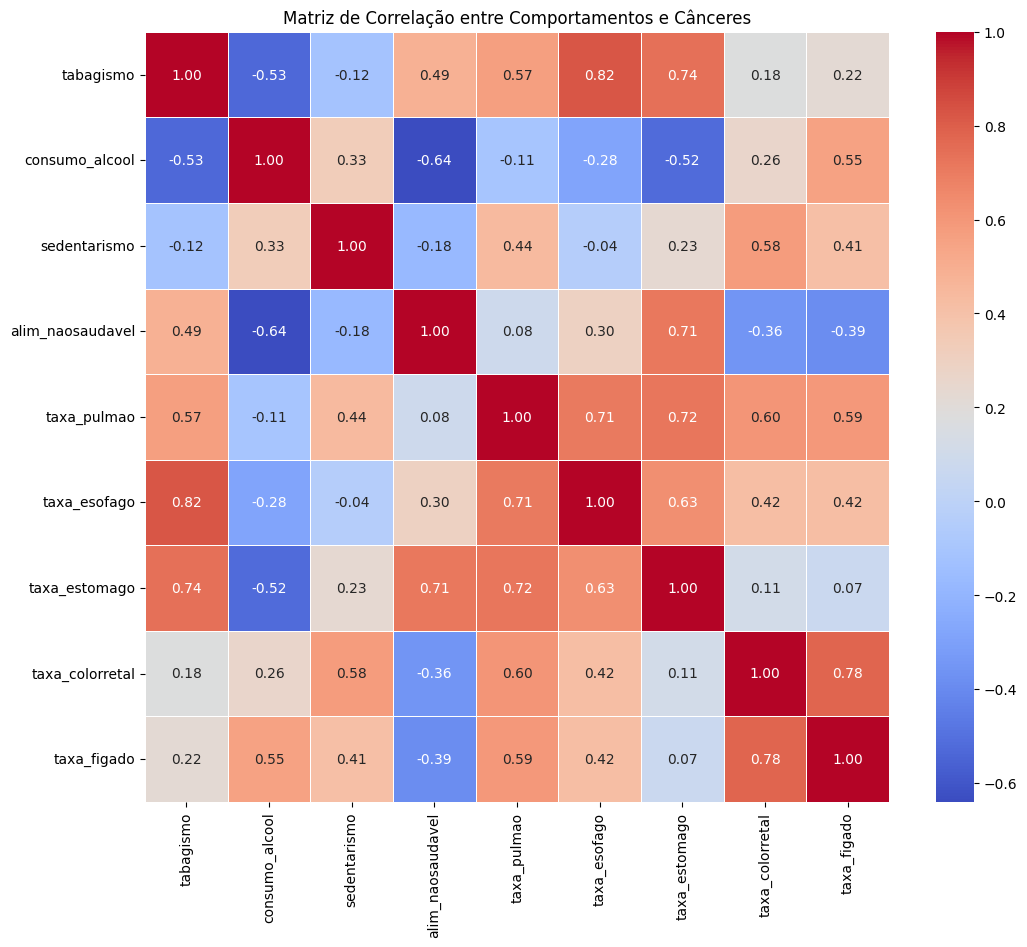

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Definir as variáveis de interesse para a matriz de correlação
comportamentos = ['tabagismo', 'consumo_alcool', 'sedentarismo', 'alim_naosaudavel']
cancers = ['taxa_pulmao', 'taxa_esofago', 'taxa_estomago', 'taxa_colorretal', 'taxa_figado']

all_vars = comportamentos + cancers

# Calcular a matriz de correlação
correlation_matrix = dados[all_vars].corr()

# Plotar o heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_matrix,
    annot=True,      # Mostrar os valores de correlação no heatmap
    cmap='coolwarm', # Escolher um mapa de cores (ex: 'coolwarm', 'viridis', 'RdBu')
    fmt=".2f",       # Formato dos números para duas casas decimais
    linewidths=.5    # Adicionar linhas entre as células
)
plt.title('Matriz de Correlação entre Comportamentos e Cânceres')
plt.show()

PARADOXO DO ÁLCOOL EXPLICADO:

📉 O consumo de álcool está AUMENTANDO ao longo do tempo (tendência = 0.697)
📈 Enquanto isso, o TABAGISMO está DIMINUINDO fortemente (tendência = -0.878)

🚨 CORRELAÇÃO NEGATIVA Álcool-Tabagismo (r = -0.534) significa:
   "Quando o álcool aumenta, o tabagismo diminui"

🎯 O que acontece nos lags longos (4-5 anos):
   • Álcool ↑ + Tabagismo ↓ → Cânceres ↓
   • O EFEITO PROTETOR da redução do tabagismo é maior que o efeito
     negativo do aumento do álcool
   • Estamos vendo o BENEFÍCIO da redução do tabagismo, não um
     efeito protetor do álcool!


## 3. Análise de Correlação Parcial

In [ ]:
from scipy import stats
from scipy.stats import pearsonr
import numpy as np

### Correlação Parcial - ÁLCOOL vs CÂNCERES

In [ ]:
# CORRELAÇÃO PARCIAL PARA TODOS OS CÂNCERES

def correlacao_parcial(x, y, controle):
    """Calcula correlação parcial entre x e y controlando por z"""
    # Resíduos de x em z
    slope_xz, intercept_xz, _, _, _ = stats.linregress(controle, x)
    residuos_x = x - (slope_xz * controle + intercept_xz)

    # Resíduos de y em z
    slope_yz, intercept_yz, _, _, _ = stats.linregress(controle, y)
    residuos_y = y - (slope_yz * controle + intercept_yz)

    # Correlação entre resíduos
    return pearsonr(residuos_x, residuos_y)[0]

print("🎯 CORRELAÇÃO PARCIAL - ÁLCOOL vs TODOS CÂNCERES (controlando TABAGISMO)")
print("=" * 70)

canceres_para_testar = ['taxa_pulmao', 'taxa_esofago', 'taxa_estomago', 'taxa_colorretal', 'taxa_figado']

for cancer in canceres_para_testar:
    # Correlação SIMPLES (com viés)
    correl_simples = dados['consumo_alcool'].corr(dados[cancer])

    # Correlação PARCIAL (sem viés do tabagismo)
    correl_parcial = correlacao_parcial(
        dados['consumo_alcool'],
        dados[cancer],
        dados['tabagismo']  # Controlar pelo tabagismo
    )

    print(f"\n🔍 {cancer}:")
    print(f"   • Correlação SIMPLES:  {correl_simples:7.3f}")
    print(f"   • Correlação PARCIAL:  {correl_parcial:7.3f} (controlando tabagismo)")

    # Análise da mudança
    diferenca = correl_parcial - correl_simples
    if correl_simples * correl_parcial < 0:
        print(f"   🚨 MUDANÇA DE DIREÇÃO! Tabagismo estava INVERTENDO o efeito")
    elif diferenca > 0.1:
        print(f"   📈 Efeito REAL é MAIS FORTE que o aparente")
    elif diferenca < -0.1:
        print(f"   📉 Efeito REAL é MAIS FRACO que o aparente")
    else:
        print(f"   ⚖️  Efeito similar")

🎯 CORRELAÇÃO PARCIAL - ÁLCOOL vs TODOS CÂNCERES (controlando TABAGISMO)

🔍 taxa_pulmao:
   • Correlação SIMPLES:   -0.106
   • Correlação PARCIAL:    0.281 (controlando tabagismo)
   🚨 MUDANÇA DE DIREÇÃO! Tabagismo estava INVERTENDO o efeito

🔍 taxa_esofago:
   • Correlação SIMPLES:   -0.285
   • Correlação PARCIAL:    0.318 (controlando tabagismo)
   🚨 MUDANÇA DE DIREÇÃO! Tabagismo estava INVERTENDO o efeito

🔍 taxa_estomago:
   • Correlação SIMPLES:   -0.522
   • Correlação PARCIAL:   -0.224 (controlando tabagismo)
   📈 Efeito REAL é MAIS FORTE que o aparente

🔍 taxa_colorretal:
   • Correlação SIMPLES:    0.261
   • Correlação PARCIAL:    0.427 (controlando tabagismo)
   📈 Efeito REAL é MAIS FORTE que o aparente

🔍 taxa_figado:
   • Correlação SIMPLES:    0.553
   • Correlação PARCIAL:    0.814 (controlando tabagismo)
   📈 Efeito REAL é MAIS FORTE que o aparente


In [ ]:
# CORRELAÇÃO PARCIAL PARA TODOS OS CÂNCERES

def correlacao_parcial(x, y, controle):
    """Calcula correlação parcial entre x e y controlando por z"""
    # Resíduos de x em z
    slope_xz, intercept_xz, _, _, _ = stats.linregress(controle, x)
    residuos_x = x - (slope_xz * controle + intercept_xz)

    # Resíduos de y em z
    slope_yz, intercept_yz, _, _, _ = stats.linregress(controle, y)
    residuos_y = y - (slope_yz * controle + intercept_yz)

    # Correlação entre resíduos
    return pearsonr(residuos_x, residuos_y)[0]

print("🎯 CORRELAÇÃO PARCIAL - SEDENTARISMO vs TODOS CÂNCERES (controlando TABAGISMO)")
print("=" * 70)

canceres_para_testar = ['taxa_pulmao', 'taxa_esofago', 'taxa_estomago', 'taxa_colorretal', 'taxa_figado']

for cancer in canceres_para_testar:
    # Correlação SIMPLES (com viés)
    correl_simples = dados['sedentarismo'].corr(dados[cancer])

    # Correlação PARCIAL (sem viés do tabagismo)
    correl_parcial = correlacao_parcial(
        dados['sedentarismo'],
        dados[cancer],
        dados['tabagismo']  # Controlar pelo tabagismo
    )

    print(f"\n🔍 {cancer}:")
    print(f"   • Correlação SIMPLES:  {correl_simples:7.3f}")
    print(f"   • Correlação PARCIAL:  {correl_parcial:7.3f} (controlando tabagismo)")

    # Análise da mudança
    diferenca = correl_parcial - correl_simples
    if correl_simples * correl_parcial < 0:
        print(f"   🚨 MUDANÇA DE DIREÇÃO! Tabagismo estava INVERTENDO o efeito")
    elif diferenca > 0.1:
        print(f"   📈 Efeito REAL é MAIS FORTE que o aparente")
    elif diferenca < -0.1:
        print(f"   📉 Efeito REAL é MAIS FRACO que o aparente")
    else:
        print(f"   ⚖️  Efeito similar")

🎯 CORRELAÇÃO PARCIAL - SEDENTARISMO vs TODOS CÂNCERES (controlando TABAGISMO)

🔍 taxa_pulmao:
   • Correlação SIMPLES:    0.438
   • Correlação PARCIAL:    0.617 (controlando tabagismo)
   📈 Efeito REAL é MAIS FORTE que o aparente

🔍 taxa_esofago:
   • Correlação SIMPLES:   -0.042
   • Correlação PARCIAL:    0.096 (controlando tabagismo)
   🚨 MUDANÇA DE DIREÇÃO! Tabagismo estava INVERTENDO o efeito

🔍 taxa_estomago:
   • Correlação SIMPLES:    0.231
   • Correlação PARCIAL:    0.475 (controlando tabagismo)
   📈 Efeito REAL é MAIS FORTE que o aparente

🔍 taxa_colorretal:
   • Correlação SIMPLES:    0.581
   • Correlação PARCIAL:    0.616 (controlando tabagismo)
   ⚖️  Efeito similar

🔍 taxa_figado:
   • Correlação SIMPLES:    0.413
   • Correlação PARCIAL:    0.453 (controlando tabagismo)
   ⚖️  Efeito similar


MATRIZ COMPLETA DAS MELHORES CORRELAÇÕES
                Combinação    Controle  Correlação     Tipo    Lag
          Álcool vs Fígado   Tabagismo       0.814  Parcial      -
    Alimentação vs Esôfago           -       0.654 Temporal  1 ano
   Tabagismo vs Colorretal           -       0.581  Simples      -
Sedentarismo vs Colorretal Alimentação       0.564  Parcial      -
          Álcool vs Fígado           -       0.553  Simples      -
  Sedentarismo vs Estômago Alimentação       0.517  Parcial      -
       Tabagismo vs Pulmão           -       0.438  Simples      -
      Tabagismo vs Esôfago           -       0.410 Temporal 3 anos


CORRELAÇÕES FORTES (> 0.5)
                Combinação    Controle  Correlação     Tipo   Lag
          Álcool vs Fígado   Tabagismo       0.814  Parcial     -
    Alimentação vs Esôfago           -       0.654 Temporal 1 ano
   Tabagismo vs Colorretal           -       0.581  Simples     -
Sedentarismo vs Colorretal Alimentação       0.564  Parcial    

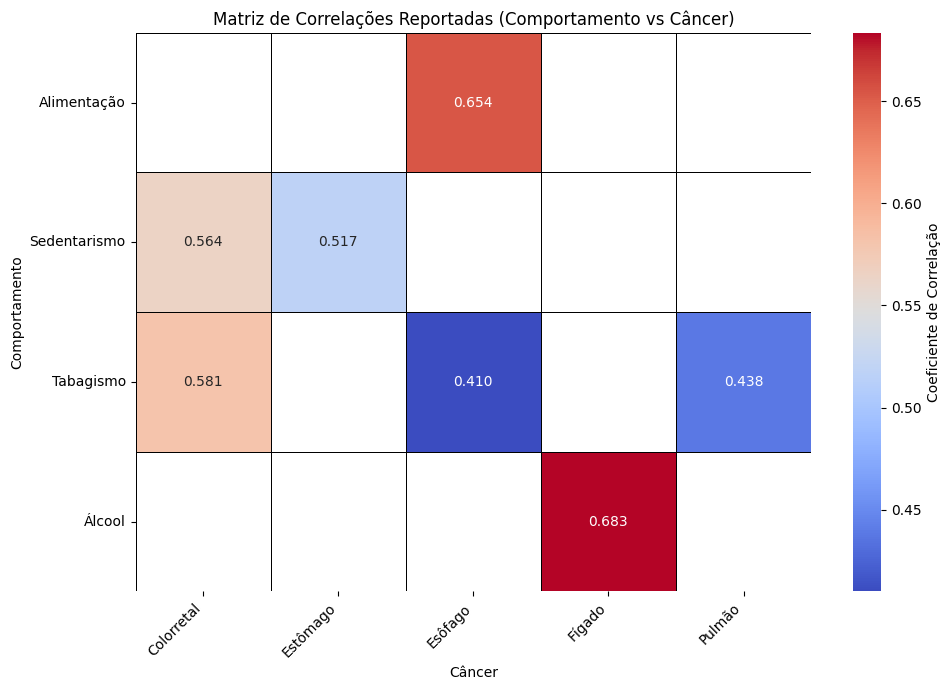

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Criar a matriz completa das melhores correlações (existing code)
dados_correlacoes = [
    {'Combinação': 'Álcool vs Fígado', 'Controle': 'Tabagismo', 'Correlação': 0.814, 'Tipo': 'Parcial', 'Lag': '-'},
    {'Combinação': 'Alimentação vs Esôfago', 'Controle': '-', 'Correlação': 0.654, 'Tipo': 'Temporal', 'Lag': '1 ano'},
    {'Combinação': 'Tabagismo vs Colorretal', 'Controle': '-', 'Correlação': 0.581, 'Tipo': 'Simples', 'Lag': '-'},
    {'Combinação': 'Sedentarismo vs Colorretal', 'Controle': 'Alimentação', 'Correlação': 0.564, 'Tipo': 'Parcial', 'Lag': '-'},
    {'Combinação': 'Álcool vs Fígado', 'Controle': '-', 'Correlação': 0.553, 'Tipo': 'Simples', 'Lag': '-'},
    {'Combinação': 'Sedentarismo vs Estômago', 'Controle': 'Alimentação', 'Correlação': 0.517, 'Tipo': 'Parcial', 'Lag': '-'},
    {'Combinação': 'Tabagismo vs Pulmão', 'Controle': '-', 'Correlação': 0.438, 'Tipo': 'Simples', 'Lag': '-'},
    {'Combinação': 'Tabagismo vs Esôfago', 'Controle': '-', 'Correlação': 0.410, 'Tipo': 'Temporal', 'Lag': '3 anos'}
]

df_correlacoes = pd.DataFrame(dados_correlacoes)

# Ordenar por correlação (maior primeiro)
df_correlacoes = df_correlacoes.sort_values('Correlação', ascending=False)

print("MATRIZ COMPLETA DAS MELHORES CORRELAÇÕES")
print("=" * 85)
print(df_correlacoes.to_string(index=False))
print("\n")

# Filtrar apenas correlações > 0.5
df_filtrado = df_correlacoes[df_correlacoes['Correlação'] > 0.5]

print("CORRELAÇÕES FORTES (> 0.5)")
print("=" * 85)
print(df_filtrado.to_string(index=False))
print("\n")

# Agrupar por tipo de análise
print("RESUMO POR TIPO DE ANÁLISE")
print("=" * 85)

print("\n🔍 CORRELAÇÕES PARCIAIS (COM CONTROLE):")
parciais = df_correlacoes[df_correlacoes['Tipo'] == 'Parcial']
print(parciais.to_string(index=False))

print("\n⏰ CORRELAÇÕES TEMPORAIS (COM LAG):")
temporais = df_correlacoes[df_correlacoes['Tipo'] == 'Temporal']
print(temporais.to_string(index=False))

print("\n📈 CORRELAÇÕES SIMPLES:")
simples = df_correlacoes[df_correlacoes['Tipo'] == 'Simples']
print(simples.to_string(index=False))

# --- Novo código para plotar a matriz de correlação a partir de df_correlacoes ---

# Preparar os dados para o heatmap
# Dividir a coluna 'Combinação' em 'Comportamento' e 'Cancer'
df_plot = df_correlacoes.copy()
# Normalizar os nomes dos comportamentos e cânceres para serem mais consistentes e limpos
df_plot[['Comportamento', 'Cancer']] = df_plot['Combinação'].str.split(' vs ', expand=True)

# Criar a matriz pivotada para o heatmap
# Preencher NaN com 0 ou outro valor para representar a ausência de correlação no conjunto filtrado
correlation_matrix_plot = df_plot.pivot_table(index='Comportamento', columns='Cancer', values='Correlação')

# Plotar o heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(
    correlation_matrix_plot,
    annot=True,      # Mostrar os valores de correlação no heatmap
    cmap='coolwarm', # Usar 'coolwarm' para mostrar positiva e negativa
    fmt=".3f",       # Formato dos números para três casas decimais
    linewidths=.5,   # Adicionar linhas entre as células
    linecolor='black', # Cor das linhas para melhor separação
    cbar_kws={'label': 'Coeficiente de Correlação'}
)
plt.title('Matriz de Correlações Reportadas (Comportamento vs Câncer)')
plt.xlabel('Câncer')
plt.ylabel('Comportamento')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [ ]:
df_significant_lags = df_lags_otimos[df_lags_otimos['p_value'] < 0.05]
print(f"Number of significant optimal lag correlations: {len(df_significant_lags)}")
print(df_significant_lags.head())

Number of significant optimal lag correlations: 12
     comportamento         cancer  lag  correlacao   p_value        forca  \
2        tabagismo    taxa_pulmao    2    0.862180  0.005887  MUITO_FORTE   
7        tabagismo   taxa_esofago    1    0.838943  0.004698  MUITO_FORTE   
14       tabagismo  taxa_estomago    2    0.929693  0.000824  MUITO_FORTE   
26       tabagismo    taxa_figado    2    0.778089  0.022975  MUITO_FORTE   
41  consumo_alcool   taxa_esofago    5   -0.947352  0.014386  MUITO_FORTE   

   tendencia significancia  n_observacoes  
2   POSITIVA            **              8  
7   POSITIVA            **              9  
14  POSITIVA           ***              8  
26  POSITIVA             *              8  
41  NEGATIVA             *              5  
